In [1]:
import os
import tensorflow as tf
import numpy as np 
from PIL import Image

In [2]:
# USE GPU to run

print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

tf.config.run_functions_eagerly(True)

True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [3]:
# Load data

def load_data():
    cur_path = os.getcwd()+'\\'
    classes = [x for x in os.listdir(cur_path) if not x.startswith('.')][:10]
    label_set = set()
    data = []
    labels = []
    for i in classes:
        if not (i.replace(cur_path, "")).startswith('.'):
            images = os.listdir(i)
            for a in images:
                if a.endswith('.jpg'):
                    image = Image.open(i + '\\' + a)
                    image = image.resize((60, 60))
                        
                    image = np.asarray(image)
                        
                    data.append(image)
                        
                    labels.append(classes.index(i.split('\\')[-1]))
                    label_set.add(i.split('\\')[-1])

    return data, labels, len(label_set) 

data, labels, num_len = load_data()

In [4]:
print("Amount of images: ", len(data))
print("Dimension of each image: ", data[0].shape)
print("Num length: ", num_len)


Amount of images:  1524
Dimension of each image:  (60, 60, 3)
Num length:  10


In [5]:
data = [i for i in data if i.shape == (60, 60, 3)]
data = np.array(data)
data = data.astype('float32')/255.0
type(data)

numpy.ndarray

In [6]:
labels = tf.one_hot(tf.cast(labels, dtype=tf.int32), num_len)
images_len = data.shape[0]

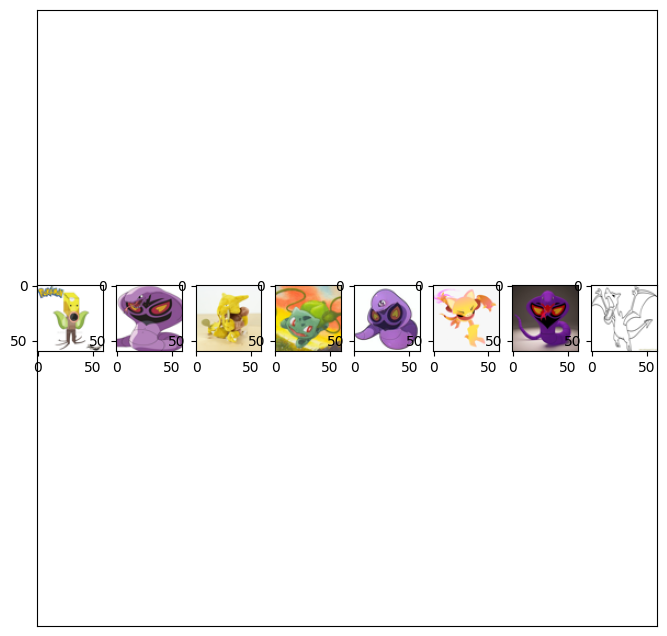

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    for i in range(len(images)):
        fig.add_subplot(1, nmax, i+1)
        plt.imshow(images[i])
    
    
def show_batch(data, nmax=64):
    random_indices = np.random.choice(images_len, nmax)
    sample_data = []
    for index in random_indices:
        sample_data.append(data[index])
    
    show_images(sample_data, nmax)
        
show_batch(data, 8)

In [14]:
# Making Discriminator Models
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, ReLU, Conv2D, LeakyReLU, BatchNormalization, Input, Flatten, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

num_classes = num_len

condition = Input(shape=(num_classes,))
img_inputs = Input(shape=(60, 60, 3))

expanded_condition = Dense(60*60*num_classes)(condition)
expanded_condition = Reshape((60,60, num_classes))(expanded_condition)

merged_inputs = Concatenate()([expanded_condition, img_inputs])


x = Conv2D(3, (3, 3), strides=2, padding='valid')(merged_inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(16, (3, 3), strides=2, padding='valid')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)


x = Conv2D(32, (3, 3), strides=2, padding='valid')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, (2, 2), strides=1, padding='valid')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
dis_output = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=[condition, img_inputs], outputs=dis_output)
discriminator.summary()

optimizer = Adam(learning_rate=0.003)
loss = BinaryCrossentropy(from_logits=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 36000)        396000      ['input_13[0][0]']               
                                                                                                  
 reshape_2 (Reshape)            (None, 60, 60, 10)   0           ['dense_8[0][0]']                
                                                                                                  
 input_14 (InputLayer)          [(None, 60, 60, 3)]  0           []                               
                                                                                            

In [18]:
# Build Generator Models
from tensorflow.keras.layers import Activation
latent_vector = 100

condition = Input(shape=(1, 1, num_classes,))
gen_input = Input(shape=(1, 1, latent_vector))

merged_inputs = concatenate([condition, gen_input])

x = Conv2DTranspose(128, 5, padding='valid', strides=1)(merged_inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# become 128 x 5 x 5
x = Conv2DTranspose(64, 5, padding='same', strides=3)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# become 64 x 15 x 15

x = Conv2DTranspose(32, 5, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# become 32 x 30 x 30

x = Conv2DTranspose(16, 5, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

#become 16 x 60 x 60

x = Conv2DTranspose(3, 1, padding='valid', strides=1)(x)
gen_output = Activation('tanh')(x)

generator = Model(inputs=[condition, gen_input], outputs=gen_output)
generator.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1, 1, 10)]   0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1, 1, 100)]  0           []                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 1, 1, 110)    0           ['input_17[0][0]',               
                                                                  'input_18[0][0]']               
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 5, 5, 128)   352128      ['concatenate_8[0][0]']    

In [10]:
#Test if generator can output correct size for image

batch_size = 32

seed_batch = tf.random.uniform((batch_size,1,1,100), minval=0, maxval=1, dtype=tf.dtypes.float32)

# Get som fake pokemon
fake_pokemon = generator(seed_batch)
print(fake_pokemon.shape)


(32, 60, 60, 3)


In [11]:
# Training function

batch_size = 32
latent_dim = 100

@tf.function
def train_step(real_images):
    random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1,latent_dim))
    generated_images = generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    
    labels += 0.05 * tf.random.uniform(labels.shape)
   
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    
    random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
    
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images

In [12]:
np.random.shuffle(data)
data = data[:-3]
print(data.shape)
np.split(data, batch_size)

(1504, 60, 60, 3)


[array([[[[1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          ...,
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ]],
 
         [[1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          ...,
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ]],
 
         [[1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          ...,
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ]],
 
         ...,
 
         [[1.       , 1.       , 1.       ],
          [1.       , 1.       , 1.       ],
          [1.       , 1.      

In [18]:
new_data = np.reshape(data, (-1, 32, 60, 60, 3))
new_data.shape

(47, 32, 60, 60, 3)

In [29]:
epochs = 100

for epoch in range(epochs):
    print("Start epoch: ", epoch)
    for step, real_images in enumerate(new_data):
        d_loss, g_loss, generated_images = train_step(real_images)
        
        if step % 200 == 0:
            print("Discriminator loss at step %d: %0.2f" % (step, d_loss))
            print("Generator loss at step %d: %0.2f" % (step, g_loss))
            
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(os.getcwd(), "generated_img" + str(step) + ".png"))

Start epoch:  0
Discriminator loss at step 0: 0.02
Generator loss at step 0: 7.92
Start epoch:  1
Discriminator loss at step 0: 0.06
Generator loss at step 0: 10.01
Start epoch:  2
Discriminator loss at step 0: 0.11
Generator loss at step 0: 6.42
Start epoch:  3
Discriminator loss at step 0: 0.04
Generator loss at step 0: 6.77
Start epoch:  4
Discriminator loss at step 0: -0.03
Generator loss at step 0: 9.64
Start epoch:  5
Discriminator loss at step 0: -0.08
Generator loss at step 0: 15.67
Start epoch:  6
Discriminator loss at step 0: -0.08
Generator loss at step 0: 12.00
Start epoch:  7
Discriminator loss at step 0: 1.68
Generator loss at step 0: 3.25
Start epoch:  8
Discriminator loss at step 0: 0.10
Generator loss at step 0: 17.61
Start epoch:  9
Discriminator loss at step 0: 0.02
Generator loss at step 0: 12.66
Start epoch:  10
Discriminator loss at step 0: 0.09
Generator loss at step 0: 8.30
Start epoch:  11
Discriminator loss at step 0: -0.02
Generator loss at step 0: 16.66
Star

Start epoch:  99
Discriminator loss at step 0: 0.69
Generator loss at step 0: 0.74


In [30]:
generated_images = generator(tf.random.normal((1,1,1,100)))

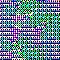

In [31]:
img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
img